# Project: OTRL
### Author: Xinyuan Yan
### xinyuanyan2016@gmail.com
**April, 2021**

**Main reference** 

1. Fontanesi, L., Gluth, S., Spektor, M. S., & Rieskamp, J. (2019). A reinforcement learning diffusion decision model for value-based decisions. Psychonomic bulletin & review, 26(4), 1099-1121.
2. Wiehler, A., & Peters, J. (2020). Diffusion modeling reveals reinforcement learning impairments in gambling disorder that are linked to attenuated ventromedial prefrontal cortex value representations. bioRxiv.

Edited code from rlssm key functions. 

Code is created and adapted by Xinyuan Yan, will be shared at her github website:
https://github.com/psywalkeryanxy

If you have any further questions, please email to me(xinyuanyan2016@gmail.com), I will provide help as much as I can ^_^

# About this dataset
**Between-subject design** 

**N(oxytocin) = **

**N(placebo)**

# Dataset can be download here:
**Xinyuan, please provide the download link here later with Dr.Ma's permission**

# Data clean / Quality control declaration

1. Discarding participants who did pass the accuray threshold
**since an accuracy above 56% across 225 trials**




**Participants were discarded in OT group, REWARD condition**

'sub42yangjian'ACC_stable1 = 0.387755102

'sub65lihao'ACC_stable1 =0.5

'RL_sub1317_XQ_data-E-post'ACC_stable1 =0.4

'RL_sub1335_SXY_data'ACC_stable1 =0.38

**Participants were discarded in PL group, REWARD condition**

'sub39zhaozijie'ACC_stable1 =0.46

# Model#1

In [1]:
#tools
#import pystan, for parameter estimation
import pystan
import pandas as pd
import scipy
import os

In [2]:
pooled_data = """
data {
	int<lower=1> N;									// number of data items
	int<lower=1> K;									// number of options
	int<lower=1> L;									// number of levels
	int<lower=1, upper=L> participant[N];			// level (participant)
	int<lower=1> trial_block[N];					// trial within block
	vector[N] f_cor;								// feedback correct option
	vector[N] f_inc;								// feedback incorrect option
	int<lower=1, upper=K> cor_option[N];			// correct option
	int<lower=1, upper=K> inc_option[N];			// incorrect option
	int<lower=1> block_label[N];					// block label

	int<lower=-1,upper=1> accuracy[N];				// accuracy (-1, 1)
	real<lower=0> rt[N];							// rt

	real initial_value;								// intial value for learning in the first block

	vector[4] alpha_priors;							// mean and sd of the prior
	vector[4] drift_scaling_priors;					// mean and sd of the prior
	vector[4] threshold_priors;						// mean and sd of the prior
	vector[4] ndt_priors;							// mean and sd of the prior
	real<lower=0, upper=1> starting_point;			// starting point diffusion model not to estimate
}
transformed data {
	vector[K] Q0;
	Q0 = rep_vector(initial_value, K);
}
"""

In [3]:
pooled_parameters = """
parameters {
	real mu_alpha;
	real mu_drift_scaling;
	real mu_threshold;
	real mu_ndt;

	real<lower=0> sd_alpha;
	real<lower=0> sd_drift_scaling;
	real<lower=0> sd_threshold;
	real<lower=0> sd_ndt;

	real z_alpha[L];
	real z_drift_scaling[L];
	real z_threshold[L];
	real z_ndt[L];
}
transformed parameters {
	real drift_ll[N];								// trial-by-trial drift rate for likelihood (incorporates accuracy)
	real drift_t[N];								// trial-by-trial drift rate for predictions
	real<lower=0> threshold_t[N];					// trial-by-trial threshold
	real<lower=0> ndt_t[N];							// trial-by-trial ndt

	vector[K] Q;									// Q state values

	real Q_mean;									// mean across all options
	real Q_mean_pres[N];							// mean Q presented options
	real delta_Q[N];								// Qcor - Qinc
	real PE_cor;									// predicion error correct option
	real PE_inc;									// predicion error incorrect option

	real<lower=0, upper=1> alpha_sbj[L];
	real<lower=0> drift_scaling_sbj[L];
	real<lower=0> threshold_sbj[L];
	real<lower=0> ndt_sbj[L];

	real transf_mu_alpha;
	real transf_mu_drift_scaling;
	real transf_mu_threshold;
	real transf_mu_ndt;

	transf_mu_alpha = Phi(mu_alpha);				// for the output
	transf_mu_drift_scaling = log(1 + exp(mu_drift_scaling));
	transf_mu_threshold = log(1 + exp(mu_threshold));
	transf_mu_ndt = log(1 + exp(mu_ndt));

	for (l in 1:L) {
		alpha_sbj[l] = Phi(mu_alpha + z_alpha[l]*sd_alpha);
		drift_scaling_sbj[l] = log(1 + exp(mu_drift_scaling + z_drift_scaling[l]*sd_drift_scaling));
		threshold_sbj[l] = log(1 + exp(mu_threshold + z_threshold[l]*sd_threshold));
		ndt_sbj[l] = log(1 + exp(mu_ndt + z_ndt[l]*sd_ndt));
	}

	for (n in 1:N) {
		if (trial_block[n] == 1) {
			if (block_label[n] == 1) {
				Q = Q0;
			} else {
				Q_mean = mean(Q);
				Q = rep_vector(Q_mean, K);
			}
		}
		Q_mean_pres[n] = (Q[cor_option[n]] + Q[inc_option[n]])/2;
		delta_Q[n] = Q[cor_option[n]] - Q[inc_option[n]];
		PE_cor = f_cor[n] - Q[cor_option[n]];
		PE_inc = f_inc[n] - Q[inc_option[n]];

		drift_t[n] = drift_scaling_sbj[participant[n]]*delta_Q[n];
		drift_ll[n] = drift_t[n]*accuracy[n];
		threshold_t[n] = threshold_sbj[participant[n]];
		ndt_t[n] = ndt_sbj[participant[n]];

		Q[cor_option[n]] = Q[cor_option[n]] + alpha_sbj[participant[n]]*PE_cor;
		Q[inc_option[n]] = Q[inc_option[n]] + alpha_sbj[participant[n]]*PE_inc;
	}
} 
"""

In [4]:
pooled_model = """
model {
	mu_alpha ~ normal(alpha_priors[1], alpha_priors[2]);
	mu_drift_scaling ~ normal(drift_scaling_priors[1], drift_scaling_priors[2]);
	mu_threshold ~ normal(threshold_priors[1], threshold_priors[2]);
	mu_ndt ~ normal(ndt_priors[1], ndt_priors[2]);

	sd_alpha ~ normal(alpha_priors[3], alpha_priors[4]);
	sd_drift_scaling ~ normal(drift_scaling_priors[3], drift_scaling_priors[4]);
	sd_threshold ~ normal(threshold_priors[3], threshold_priors[4]);
	sd_ndt ~ normal(ndt_priors[3], ndt_priors[4]);

	z_alpha ~ normal(0, 1);
	z_drift_scaling ~ normal(0, 1);
	z_threshold ~ normal(0, 1);
	z_ndt ~ normal(0, 1);

	rt ~ wiener(threshold_t, ndt_t, starting_point, drift_ll);
}
generated quantities {
	vector[N] log_lik;

	{for (n in 1:N) {
		log_lik[n] = wiener_lpdf(rt[n] | threshold_t[n], ndt_t[n], starting_point, drift_ll[n]);
	}
	}
}
"""

In [5]:
#The sampling methods in PyStan require the data to be input as a Python dictionary whose keys match
#the data block of the Stan code.


data = pd.read_csv('data_OT_REWARD_200.csv')
model_label = 'hierRLDDM'#####PLEASE PAY ATTENTION!!!!
# learning parameters
N = data.shape[0] # n observations
K = 2 # n options in a learning block (participants see 2 at a time)
L = len(pd.unique(data.participant)) 

initial_value_learning = 0.5 # intitial learning value (Q0)

alpha_priors={'mu_mu':0, 'sd_mu':1, 'mu_sd':0, 'sd_sd':.1}

drift_scaling_priors={'mu_mu':1, 'sd_mu':30, 'mu_sd':0, 'sd_sd':30}

threshold_priors={'mu_mu':1, 'sd_mu':3, 'mu_sd':0, 'sd_sd':3}

ndt_priors={'mu_mu':1, 'sd_mu':1, 'mu_sd':0, 'sd_sd':1}

# transform data variables
data['accuracy_neg'] = -1
data.loc[data.accuracy == 1, 'accuracy_neg'] = 1

In [6]:
data #view data

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy,accuracy_neg
0,1,1,1,1,0,2,1,1,1.427829,0,-1
1,1,1,2,1,0,1,2,2,0.849174,0,-1
2,1,1,3,1,0,1,2,3,1.749040,1,1
3,1,1,4,1,0,2,1,4,0.806818,0,-1
4,1,1,5,1,0,2,1,5,1.596714,1,1
...,...,...,...,...,...,...,...,...,...,...,...
11230,51,7,46,1,0,2,1,221,0.494948,1,1
11231,51,7,47,1,0,1,2,222,0.411379,0,-1
11232,51,7,48,1,0,1,2,223,0.330851,0,-1
11233,51,7,49,1,0,2,1,224,0.812914,0,-1


In [7]:
#define priors
priors = dict(
                alpha_priors={'mu_mu':0, 'sd_mu':1, 'mu_sd':0, 'sd_sd':.1},
                alpha_pos_priors={'mu_mu':0, 'sd_mu':1, 'mu_sd':0, 'sd_sd':.1},
                alpha_neg_priors={'mu_mu':0, 'sd_mu':1, 'mu_sd':0, 'sd_sd':.1},
                drift_scaling_priors={'mu_mu':1, 'sd_mu':30, 'mu_sd':0, 'sd_sd':30},
                drift_asymptote_priors={'mu_mu':1, 'sd_mu':30, 'mu_sd':0, 'sd_sd':30},
                threshold_priors={'mu_mu':1, 'sd_mu':3, 'mu_sd':0, 'sd_sd':3},
                threshold_modulation_priors={'mu_mu':0, 'sd_mu':10, 'mu_sd':0, 'sd_sd':10},
                ndt_priors={'mu_mu':1, 'sd_mu':1, 'mu_sd':0, 'sd_sd':1}
                )
priors['alpha_priors'] = alpha_priors
priors['drift_scaling_priors'] = drift_scaling_priors
priors['threshold_priors'] = threshold_priors
#priors['threshold_modulation_priors'] = threshold_modulation_priors
priors['ndt_priors'] = ndt_priors



In [11]:
sm = pystan.StanModel(model_code=pooled_data + pooled_parameters + pooled_model)

#define data

data_dict = {'N': N,
             'K': K,
             'L': L,
             'participant': data['participant'].values.astype(int),
             'trial_block': data['trial_block'].values.astype(int),
             'f_cor': data['f_cor'].values,
             'f_inc': data['f_inc'].values,
             'cor_option': data['cor_option'].values.astype(int),
             'inc_option': data['inc_option'].values.astype(int),
             'block_label': data['block_label'].values.astype(int),
             'rt': data['rt'].values,
             'accuracy': data['accuracy_neg'].values.astype(int),
             'initial_value': initial_value_learning,
             'alpha_priors':[0,1,0,0.1],
             'drift_scaling_priors':[1,3,0,3],
             'threshold_priors':[1,3,0,3],
             'ndt_priors':[1,1,0,1],
             'starting_point': .5}
    



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bc4dd4dced0824789d173a170c757d92 NOW.


LinkError: command 'x86_64-apple-darwin13.4.0-clang++' failed with exit status 1

In [30]:
fit = sm.sampling(data_dict,iter=1000, chains=2,n_jobs=2
                 )

#print(fit)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [31]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': False,
 'Rhat': False,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [32]:
loglik = fit['log_lik']

## Posterior predictive check analysis preparation

In [33]:
print(fit)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [34]:
import numpy as np
import pandas as pd
from scipy import stats
import random

## pure DDM
def random_ddm(drift, threshold, ndt, rel_sp=.5, noise_constant=1, dt=0.001, max_rt=10):
    """Simulates behavior (rt and accuracy) according to the diffusion decision model.

    In this parametrization, it is assumed that 0 is the lower threshold,
    and, when rel_sp=1/2, the diffusion process starts halfway through the threshold value.

    Note
    ----

    This function is mainly for the posterior predictive calculations.
    It assumes that drift, threshold and ndt are provided as numpy.ndarray
    of shape (n_samples, n_trials).

    However, it also works when the rel_sp is given as a float.
    Drift, threshold and ndt should have the same shape.

    Parameters
    ----------

    drift : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Drift-rate of the diffusion decision model.

    threshold : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Threshold of the diffusion decision model.

    ndt : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Non decision time of the diffusion decision model, in seconds.

    Other Parameters
    ----------------

    rel_sp : numpy.ndarray or float, default .5
        When is an array , shape is usually (n_samples, n_trials).
        Relative starting point of the diffusion decision model.

    noise_constant : float, default 1
        Scaling factor of the diffusion decision model.
        If changed, drift and threshold would be scaled accordingly.
        Not to be changed in most applications.

    max_rt : float, default 10
        Controls the maximum rts that can be predicted.
        Making this higher might make the function a bit slower.

    dt : float, default 0.001
        Controls the time resolution of the diffusion decision model. Default is 1 msec.
        Lower values of dt make the function more precise but much slower.

    Returns
    -------

    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the diffusion decision model.
        Every element corresponds to the set of parameters given as input with the same shape.

    acc: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated accuracy according to the diffusion decision model.
        Every element corresponds to the set of parameters given as input with the same shape.

    """

    shape = drift.shape

    acc = np.empty(shape)
    acc[:] = np.nan
    rt = np.empty(shape)
    rt[:] = np.nan
    rel_sp = np.ones(shape)*rel_sp
    max_tsteps = max_rt/dt

    # initialize the diffusion process
    x = np.ones(shape)*rel_sp*threshold
    tstep = 0
    ongoing = np.array(np.ones(shape), dtype=bool)

    # start accumulation process
    while np.sum(ongoing) > 0 and tstep < max_tsteps:
        x[ongoing] += np.random.normal(drift[ongoing]*dt,
                                       noise_constant*np.sqrt(dt),
                                       np.sum(ongoing))
        tstep += 1

        # ended trials
        ended_correct = (x >= threshold)
        ended_incorrect = (x <= 0)

        # store results and filter out ended trials
        if np.sum(ended_correct) > 0:
            acc[np.logical_and(ended_correct, ongoing)] = 1
            rt[np.logical_and(ended_correct, ongoing)] = dt*tstep + ndt[np.logical_and(ended_correct,
                                                                                       ongoing)]
            ongoing[ended_correct] = False

        if np.sum(ended_incorrect) > 0:
            acc[np.logical_and(ended_incorrect, ongoing)] = 0
            rt[np.logical_and(ended_incorrect, ongoing)] = dt*tstep + ndt[np.logical_and(ended_incorrect,
                                                                                         ongoing)]
            ongoing[ended_incorrect] = False

    return rt, acc

# Check all diagnostics

In [35]:
import rlssm
from rlssm import stan_utility

In [36]:
stan_utility.check_n_eff(fit)

n_eff / iter looks reasonable for all parameters


In [37]:
stan_utility.check_all_diagnostics(fit)

Checks MCMC diagnostics:
n_eff / iter looks reasonable for all parameters
0.0 of 1000 iterations ended with a divergence (0.0%)
0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [38]:
from rlssm import fits

In [39]:
sampler_params = fit.get_sampler_params(inc_warmup=False)

In [40]:
from __future__ import absolute_import, division, print_function
import os
import re
import pickle
import warnings
import pickle
from math import isnan
from math import isinf
from hashlib import md5
import pystan
import numpy

def check_div(fit):
    """Check transitions that ended with a divergence.

    Parameters
    ----------

    fit : pystan.StanFit4model
        The fitted stan model.

    """
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    divergent = [x for y in sampler_params for x in y['divergent__']]
    n = sum(divergent)
    N = len(divergent)
    print('{} of {} iterations ended with a divergence ({}%)'.format(n, N, 100 * n / N))
    if n > 0:
        print('  Try running with larger adapt_delta to remove the divergences')

def check_treedepth(fit, max_depth=10):
    """Check transitions that ended prematurely due to maximum tree depth limit.

    Parameters
    ----------

    fit : pystan.StanFit4model
        The fitted stan model.

    max_depth : int
        Maximum tree depth.

    """
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    depths = [x for y in sampler_params for x in y['treedepth__']]
    n = sum(1 for x in depths if x == max_depth)
    N = len(depths)
    print(('{} of {} iterations saturated the maximum tree depth of {}' +
           ' ({}%)').format(n, N, max_depth, 100 * n / N))
    if n > 0:
        print('Run again with max_depth set to a larger value to avoid saturation')

def check_energy(fit):
    """Checks the energy Bayesian fraction of missing information (E-BFMI).

    Parameters
    ----------

    fit : pystan.StanFit4model
        The fitted stan model.

    """
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    no_warning = True
    for chain_num, s in enumerate(sampler_params):
        energies = s['energy__']
        numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
        denom = numpy.var(energies)
        if numer / denom < 0.2:
            print('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
            no_warning = False
    if no_warning:
        print('E-BFMI indicated no pathological behavior')
    else:
        print('  E-BFMI below 0.2 indicates you may need to reparameterize your model')

def check_n_eff(fit):
    """Checks the effective sample size per iteration.

    Parameters
    ----------

    fit : pystan.StanFit4model
        The fitted stan model.

    """
    fit_summary = fit.summary(probs=[0.5])
    n_effs = [x[4] for x in fit_summary['summary']]
    names = fit_summary['summary_rownames']
    n_iter = len(fit.extract()['lp__'])

    no_warning = True
    for n_eff, name in zip(n_effs, names):
        ratio = n_eff / n_iter
        if ratio < 0.001:
            print('n_eff / iter for parameter {} is {}!'.format(name, ratio))
            print('E-BFMI below 0.2 indicates you may need to reparameterize your model')
            no_warning = False
    if no_warning:
        print('n_eff / iter looks reasonable for all parameters')
    else:
        print('n_eff / iter below 0.001 indicates that the effective sample size has likely been overestimated')

def check_rhat(fit):
    """Checks the potential scale reduction factors.

    Parameters
    ----------

    fit : pystan.StanFit4model
        The fitted stan model.

    """
    fit_summary = fit.summary(probs=[0.5])
    rhats = [x[5] for x in fit_summary['summary']]
    names = fit_summary['summary_rownames']

    no_warning = True
    for rhat, name in zip(rhats, names):
        if (rhat > 1.01 or isnan(rhat) or isinf(rhat)):
            print('Rhat for parameter {} is {}!'.format(name, rhat))
            no_warning = False
    if no_warning:
        print('Rhat looks reasonable for all parameters')
    else:
        print('Rhat above 1.01 indicates that the chains very likely have not mixed')

def check_all_diagnostics(fit):
    """Checks all MCMC diagnostics, apart from rhat convergence.

    Parameters
    ----------

    fit : pystan.StanFit4model
        The fitted stan model.

    """
    print("Checks MCMC diagnostics:")
    check_n_eff(fit)
    check_div(fit)
    check_treedepth(fit)
    check_energy(fit)

def _by_chain(unpermuted_extraction):
    num_chains = len(unpermuted_extraction[0])
    result = [[] for _ in range(num_chains)]
    for c in range(num_chains):
        for i in range(len(unpermuted_extraction)):
            result[c].append(unpermuted_extraction[i][c])
    return numpy.array(result)

def _shaped_ordered_params(fit):
    # flattened, unpermuted, by (iteration, chain)
    ef = fit.extract(permuted=False, inc_warmup=False)
    ef = _by_chain(ef)
    ef = ef.reshape(-1, len(ef[0][0]))
    ef = ef[:, 0:len(fit.flatnames)] # drop lp__
    shaped = {}
    idx = 0
    for dim, param_name in zip(fit.par_dims, fit.extract().keys()):
        length = int(numpy.prod(dim))
        shaped[param_name] = ef[:, idx:idx + length]
        shaped[param_name].reshape(*([-1] + dim))
        idx += length
    return shaped

def partition_div(fit):
    """Returns parameter arrays separated into divergent and non-divergent transitions.

    Parameters
    ----------

    fit : pystan.StanFit4model
        The fitted stan model.

    Returns
    -------

    nondiv_params : dict
        Dictionary containing the non-divergent transitions per parameter.

    div_params : dict
        Dictionary containing the divergent transitions per parameter.

    """
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    div = numpy.concatenate([x['divergent__'] for x in sampler_params]).astype('int')
    params = _shaped_ordered_params(fit)
    nondiv_params = dict((key, params[key][div == 0]) for key in params)
    div_params = dict((key, params[key][div == 1]) for key in params)
    return nondiv_params, div_params


In [41]:
check_energy(fit)

E-BFMI indicated no pathological behavior


## Extracts the last posterior estimates values in each chain

In [42]:
from rlssm import fits_DDM

In [43]:
hierarchical_levels = 2

family = 'RLDDM'
n_parameters_individual = 5
n_parameters_trial=0
print_diagnostics =True


In [44]:
fits_DDM.DDMFittedModel.stan_model = fit

In [45]:
fits_DDM.DDMFittedModel.model_label = model_label
fits_DDM.DDMFittedModel.family = family
fits_DDM.DDMFittedModel.priors = priors

# setting key paramter information for fitted DDM

In [46]:
fits_DDM.DDMFittedModel.data_info = {'N': data.shape[0], 'data':data}

n_samples_after_warmup = fits_DDM.DDMFittedModel.stan_model.stan_args[0]['iter'] - fits_DDM.DDMFittedModel.stan_model.stan_args[0]['warmup']
n_posterior_samples = n_samples_after_warmup / fits_DDM.DDMFittedModel.stan_model.stan_args[0]['thin']*len(fits_DDM.DDMFittedModel.stan_model.stan_args)


In [47]:
fits_DDM.DDMFittedModel.parameters_info = {'hierarchical_levels': hierarchical_levels,
                                'n_parameters_individual':n_parameters_individual,
                                'n_parameters_trial': n_parameters_trial,
                                'n_posterior_samples': int(n_posterior_samples)}


fits_DDM.DDMFittedModel.data_info.update({'L': len(pd.unique(data.participant))})
fits_DDM.DDMFittedModel.parameters_info.update({'n_parameters_group': n_parameters_individual*2,
                                         'n_parameters_hierarchical': n_parameters_individual*2 + n_parameters_individual*fits_DDM.DDMFittedModel.data_info['L']})

r = re.compile("transf_.+")
parameters_names_transf = list(filter(r.match, fits_DDM.DDMFittedModel.stan_model.flatnames))
individual_parameters_names = [name[10:] for name in parameters_names_transf]

r = re.compile("mu_.+")
group_parameters_mu = list(filter(r.match, fits_DDM.DDMFittedModel.stan_model.flatnames))
r = re.compile("sd_.+")
group_parameters_sd = list(filter(r.match, fits_DDM.DDMFittedModel.stan_model.flatnames))

group_parameters_names_transf = parameters_names_transf + group_parameters_sd # add transformed par names for plotting
group_parameters_names = group_parameters_mu + group_parameters_sd

r = re.compile("z_.+_trial.+")
trials_deviations = list(filter(r.match, fits_DDM.DDMFittedModel.stan_model.flatnames))

r = re.compile("z_.+")
individual_deviations = list(filter(r.match, fits_DDM.DDMFittedModel.stan_model.flatnames))

if len(trials_deviations) > 0:
    [individual_deviations.remove(el) for el in trials_deviations]

parameters_names = group_parameters_names + individual_deviations
parameters_names_all = parameters_names + trials_deviations

fits_DDM.DDMFittedModel.parameters_info.update({'parameters_names': parameters_names, # group parameters and individual deviations
                                         'group_parameters_names': group_parameters_names, # group parameters
                                         'individual_parameters_names': individual_parameters_names, # names of individual parameters
                                         'group_parameters_names_transf': parameters_names_transf, # group parameters for plotting
                                         'parameters_names_all': parameters_names_all}) # all parameters for the rhat calculations


# Calculates rhat

In [48]:
def get_rhat(self):
        """Extracts rhat from stan model's summary as a pandas dataframe.
        Only considers parameters (Not all variables specified in stan's model).
        Note that, when DDM parameters are estimated at a trial level, these are included in the rhat stats.

        Returns
        -------

        convergence: DataFrame
            Data frame with rows the parameters and columns the rhat and variable names.

        """
        summary = self.stan_model.summary(pars=self.parameters_info['parameters_names_all'])
        convergence = pd.DataFrame({'rhat': np.array(summary['summary'])[:, 9],
                                    'variable': summary['summary_rownames']})
        return convergence

In [49]:
get_rhat(fits_DDM.DDMFittedModel)


,rhat,variable
0,0.999246,mu_alpha
1,1.001892,mu_drift_scaling
2,1.000440,mu_threshold
3,1.029144,mu_ndt
4,1.003151,sd_alpha
...,...,...
107,1.027241,z_ndt[22]
108,1.013099,z_ndt[23]
109,1.025241,z_ndt[24]
110,1.021191,z_ndt[25]


# Calculates the Watanabe-Akaike information criteria.

In [50]:
    def calculate_waic(self, pointwise=False):
        """Calculates the Watanabe-Akaike information criteria.

        Calculates pWAIC1 and pWAIC2
        according to http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf

        Parameters
        ----------

        pointwise : bool, default to False
            By default, gives the averaged waic.
            Set to True is you want additional waic per observation.

        Returns
        -------

        out: dict
            Dictionary containing lppd (log pointwise predictive density),
            p_waic, waic, waic_se (standard error of the waic), and
            pointwise_waic (when `pointwise` is True).

        """
        log_likelihood = self.stan_model['log_lik'] # n_samples X N observations
        likelihood = np.exp(log_likelihood)

        mean_l = np.mean(likelihood, axis=0) # N observations

        pointwise_lppd = np.log(mean_l)
        lppd = np.sum(pointwise_lppd)

        pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
        var_l = np.sum(pointwise_var_l)

        pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
        waic = -2*lppd + 2*var_l
        waic_se = np.sqrt(self.data_info['N'] * np.var(pointwise_waic))

        if pointwise:
            out = {'lppd':lppd,
                   'p_waic':var_l,
                   'waic':waic,
                   'waic_se':waic_se,
                   'pointwise_waic':pointwise_waic}
        else:
            out = {'lppd':lppd,
                   'p_waic':var_l,
                   'waic':waic,
                   'waic_se':waic_se}
        return out

In [51]:
calculate_waic(fits_DDM.DDMFittedModel,pointwise=False)

{'lppd': -670.5569137050618,
 'p_waic': 132.08899759798925,
 'waic': 1605.291822606102,
 'waic_se': 185.45244060567714}

## Extracts the last posterior estimates values in each chain

In [52]:
    def get_last_values(self):
        """Extracts the last posterior estimates values in each chain.

        Returns
        -------

        starting_points: DataFrame
             Data frame with as many rows as number of chains that were run.
             Parameter values are in separate columns.

        """
        samplesChains = self.stan_model.to_dataframe(pars=self.parameters_info['parameters_names_all'],
                                                     permuted=False,
                                                     diagnostics=False)
        starting_points = samplesChains[samplesChains['draw'] == max(samplesChains['draw'])]

        return starting_points

In [53]:
get_last_values(fits_DDM.DDMFittedModel)

,chain,draw,warmup,mu_alpha,mu_drift_scaling,mu_ndt,mu_threshold,sd_alpha,sd_drift_scaling,sd_ndt,...,z_threshold[25],z_threshold[26],z_threshold[2],z_threshold[3],z_threshold[4],z_threshold[5],z_threshold[6],z_threshold[7],z_threshold[8],z_threshold[9]
499,0,499,0,-0.317821,2.400149,-1.314574,0.867637,0.516985,1.416206,0.228376,...,-1.570970,-0.183566,0.886075,0.929276,3.376794,0.255745,0.823514,0.853557,0.238764,0.124827
999,1,499,0,-0.445689,1.485573,-1.218856,1.015932,0.454298,1.915648,0.185287,...,-1.767645,-1.268477,0.100287,0.078073,2.370765,-0.417724,0.204523,0.590331,-0.545381,-0.244102


In [54]:
trial_samples = fit.extract(['drift_t', 'threshold_t', 'ndt_t'])
samples = fit.to_dataframe()

fits_DDM.DDMFittedModel.model_label = model_label
#fits_DDM.DDMFittedModel.data_info = data_info
#fits_DDM.DDMFittedModel.parameters_info = parameters_info
fits_DDM.DDMFittedModel.priors = priors
fits_DDM.DDMFittedModel.rhat = rhat
fits_DDM.DDMFittedModel.waic = waic
fits_DDM.DDMFittedModel.last_values = last_values
fits_DDM.DDMFittedModel.samples = samples
fits_DDM.DDMFittedModel.trial_samples = trial_samples

NameError: name 'rhat' is not defined

# Posterior predictive check

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import random

## pure DDM
def random_ddm(drift, threshold, ndt, rel_sp=.5, noise_constant=1, dt=0.001, max_rt=10):
    """Simulates behavior (rt and accuracy) according to the diffusion decision model.

    In this parametrization, it is assumed that 0 is the lower threshold,
    and, when rel_sp=1/2, the diffusion process starts halfway through the threshold value.

    Note
    ----

    This function is mainly for the posterior predictive calculations.
    It assumes that drift, threshold and ndt are provided as numpy.ndarray
    of shape (n_samples, n_trials).

    However, it also works when the rel_sp is given as a float.
    Drift, threshold and ndt should have the same shape.

    Parameters
    ----------

    drift : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Drift-rate of the diffusion decision model.

    threshold : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Threshold of the diffusion decision model.

    ndt : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Non decision time of the diffusion decision model, in seconds.

    Other Parameters
    ----------------

    rel_sp : numpy.ndarray or float, default .5
        When is an array , shape is usually (n_samples, n_trials).
        Relative starting point of the diffusion decision model.

    noise_constant : float, default 1
        Scaling factor of the diffusion decision model.
        If changed, drift and threshold would be scaled accordingly.
        Not to be changed in most applications.

    max_rt : float, default 10
        Controls the maximum rts that can be predicted.
        Making this higher might make the function a bit slower.

    dt : float, default 0.001
        Controls the time resolution of the diffusion decision model. Default is 1 msec.
        Lower values of dt make the function more precise but much slower.

    Returns
    -------

    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the diffusion decision model.
        Every element corresponds to the set of parameters given as input with the same shape.

    acc: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated accuracy according to the diffusion decision model.
        Every element corresponds to the set of parameters given as input with the same shape.

    """

    shape = drift.shape

    acc = np.empty(shape)
    acc[:] = np.nan
    rt = np.empty(shape)
    rt[:] = np.nan
    rel_sp = np.ones(shape)*rel_sp
    max_tsteps = max_rt/dt

    # initialize the diffusion process
    x = np.ones(shape)*rel_sp*threshold
    tstep = 0
    ongoing = np.array(np.ones(shape), dtype=bool)

    # start accumulation process
    while np.sum(ongoing) > 0 and tstep < max_tsteps:
        x[ongoing] += np.random.normal(drift[ongoing]*dt,
                                       noise_constant*np.sqrt(dt),
                                       np.sum(ongoing))
        tstep += 1

        # ended trials
        ended_correct = (x >= threshold)
        ended_incorrect = (x <= 0)

        # store results and filter out ended trials
        if np.sum(ended_correct) > 0:
            acc[np.logical_and(ended_correct, ongoing)] = 1
            rt[np.logical_and(ended_correct, ongoing)] = dt*tstep + ndt[np.logical_and(ended_correct,
                                                                                       ongoing)]
            ongoing[ended_correct] = False

        if np.sum(ended_incorrect) > 0:
            acc[np.logical_and(ended_incorrect, ongoing)] = 0
            rt[np.logical_and(ended_incorrect, ongoing)] = dt*tstep + ndt[np.logical_and(ended_incorrect,
                                                                                         ongoing)]
            ongoing[ended_incorrect] = False

    return rt, acc

In [56]:
    def get_posterior_predictives(self, n_posterior_predictives=500, **kwargs):
        starting_point_bias = False
        """Calculates posterior predictives of choices and response times.

        Parameters
        ----------

        n_posterior_predictives : int
             Number of posterior samples to use for posterior predictives calculation.
             If n_posterior_predictives is bigger than the posterior samples,
             then calculation will continue with the total number of posterior samples.

        Other Parameters
        ----------------

        noise_constant : float
            Scaling factor of the diffusion decision model.
            If changed, drift and threshold would be scaled accordingly.
            Not to be changed in most applications.

        rt_max : float
            Controls the maximum rts that can be predicted.
            Making this higher might make the function a bit slower.

        dt : float
            Controls the time resolution of the diffusion decision model. Default is 1 msec.
            Lower values of dt make the function more precise but much slower.

        Returns
        -------

        pp_rt : np.ndarray
            Array of shape (n_samples, n_trials) containing predicted response times.

        pp_acc : np.ndarray
            Array of shape (n_samples, n_trials) containing predicted choices.

        """

        if n_posterior_predictives > self.parameters_info['n_posterior_samples']:
            warnings.warn("Cannot have more posterior predictive samples than posterior samples. " \
                          "Will continue with n_posterior_predictives=%s" % self.parameters_info['n_posterior_samples'],
                          UserWarning,
                          stacklevel=2)
            n_posterior_predictives = self.parameters_info['n_posterior_samples']

        drift_t = trial_samples['drift_t'][:n_posterior_predictives, :]
        threshold_t = trial_samples['threshold_t'][:n_posterior_predictives, :]
        ndt_t = trial_samples['ndt_t'][:n_posterior_predictives, :]

        if starting_point_bias:
            rel_sp_t = trial_samples['rel_sp_t'][:n_posterior_predictives, :]
            pp_rt, pp_acc = random_ddm(drift_t, threshold_t, ndt_t, rel_sp=rel_sp_t, **kwargs)
        else:
            pp_rt, pp_acc = random_ddm(drift_t, threshold_t, ndt_t, rel_sp=.5, **kwargs)
        return pp_rt, pp_acc

    def get_posterior_predictives_df(self, n_posterior_predictives=500, **kwargs):
        """Calculates posterior predictives of choices and response times.

        Parameters
        ----------

        n_posterior_predictives : int
             Number of posterior samples to use for posterior predictives calculation.
             If n_posterior_predictives is bigger than the posterior samples,
             then calculation will continue with the total number of posterior samples.

        Other Parameters
        ----------------

        noise_constant : float
            Scaling factor of the diffusion decision model.
            If changed, drift and threshold would be scaled accordingly.
            Not to be changed in most applications.

        rt_max : float
            Controls the maximum rts that can be predicted.
            Making this higher might make the function a bit slower.

        dt : float
            Controls the time resolution of the diffusion decision model. Default is 1 msec.
            Lower values of dt make the function more precise but much slower.

        Returns
        -------

        out : DataFrame
            Data frame of shape (n_samples, n_trials*2).
            Response times and accuracy are provided as hierarchical column indeces.

        """
        pp_rt, pp_acc = get_posterior_predictives(self,n_posterior_predictives, **kwargs)

        tmp1 = pd.DataFrame(pp_rt,
                            index=pd.Index(np.arange(1, len(pp_rt)+1), name='sample'),
                            columns=pd.MultiIndex.from_product((['rt'],
                                                                np.arange(pp_rt.shape[1])+1),
                                                               names=['variable', 'trial']))
        tmp2 = pd.DataFrame(pp_acc,
                            index=pd.Index(np.arange(1, len(pp_acc)+1), name='sample'),
                            columns=pd.MultiIndex.from_product((['accuracy'],
                                                                np.arange(pp_acc.shape[1])+1),
                                                               names=['variable', 'trial']))
        out = pd.concat((tmp1, tmp2), axis=1)
        return out

    
    def get_posterior_predictives_summary(self,
                                          n_posterior_predictives=500,
                                          quantiles=None,
                                          **kwargs):
        """Calculates summary of posterior predictives of choices and response times.

        The mean proportion of choices (in this case coded as accuracy) is calculated
        for each posterior sample across all trials.
        Response times are summarized using mean, skewness, and quantiles.

        Parameters
        ----------

        n_posterior_predictives : int
             Number of posterior samples to use for posterior predictives calculation.
             If n_posterior_predictives is bigger than the posterior samples,
             then calculation will continue with the total number of posterior samples.

        quantiles : list of floats
             Quantiles to summarize response times distributions
             (separately for correct/incorrect) with.
             Default to [.1, .3, .5, .7, .9].

        Other Parameters
        ----------------

        noise_constant : float
            Scaling factor of the diffusion decision model.
            If changed, drift and threshold would be scaled accordingly.
            Not to be changed in most applications.

        rt_max : float
            Controls the maximum rts that can be predicted.
            Making this higher might make the function a bit slower.

        dt : float
            Controls the time resolution of the diffusion decision model. Default is 1 msec.
            Lower values of dt make the function more precise but much slower.

        Returns
        -------

        out : DataFrame
            Pandas DataFrame, where every row corresponds to a posterior sample.
            The columns contains the mean accuracy for each posterior sample,
            as well as mean response times, response times skewness and response times quantiles.

        """
        if quantiles is None:
            quantiles = [.1, .3, .5, .7, .9]

        pp = get_posterior_predictives_df(self,
            n_posterior_predictives=n_posterior_predictives,
            **kwargs)

        tmp = pd.DataFrame({'mean_accuracy': pp['accuracy'].mean(axis=1),
                            'mean_rt': pp['rt'].mean(axis=1),
                            'skewness': pp['rt'].skew(axis=1, skipna=True)})

        pp_rt_low = pp['rt'][pp['accuracy'] == 0] # lower boundary (usually incorrect)
        pp_rt_up = pp['rt'][pp['accuracy'] == 1] # upper boundary (usually correct)

        q_low = pp_rt_low.quantile(q=quantiles, axis=1).T
        q_up = pp_rt_up.quantile(q=quantiles, axis=1).T

        q_low.columns = ['quant_{}_rt_low'.format(int(c*100)) for c in q_low.columns]
        q_up.columns = ['quant_{}_rt_up'.format(int(c*100)) for c in q_up.columns]

        out = pd.concat([tmp, q_low, q_up], axis=1)

        return out

In [57]:
get_posterior_predictives(fits_DDM.DDMFittedModel, n_posterior_predictives=500)

(array([[0.92475994, 0.86375994, 0.30575994, ..., 0.31615807, 0.60715807,
         0.68115807],
        [1.27986898, 0.76886898, 0.65386898, ..., 0.45406389, 0.47806389,
         0.56606389],
        [1.57506216, 0.42606216, 0.60906216, ..., 0.51636242, 0.47736242,
         0.37336242],
        ...,
        [0.88593212, 0.45093212, 0.45193212, ..., 0.58068832, 0.34968832,
         0.52168832],
        [0.83584109, 0.87284109, 1.06684109, ..., 0.30822087, 0.34822087,
         0.43722087],
        [0.40912721, 0.82112721, 0.42712721, ..., 0.6475516 , 0.6165516 ,
         0.8485516 ]]),
 array([[0., 1., 1., ..., 1., 0., 1.],
        [0., 1., 1., ..., 0., 0., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 0., 1.],
        [0., 1., 1., ..., 1., 0., 0.]]))

In [58]:
pp_df = get_posterior_predictives_summary(fits_DDM.DDMFittedModel,n_posterior_predictives=500)

### plotting functions

In [59]:

    def plot_mean_posterior_predictives(self,
                                        n_posterior_predictives,
                                        figsize=(20, 8),
                                        post_pred_kws=None,
                                        **kwargs):
        """Plots the mean posterior predictives of choices and response times.

        The mean proportion of choices (in this case coded as accuracy) is calculated
        for each posterior sample across all trials,
        and then it's plotted as a distribution.
        The mean accuracy in the data is plotted as vertical line.
        This allows to compare the real mean with the BCI or HDI of the predictions.
        The same is done for response times, and are plotted one next to each other.

        Parameters
        ----------

        n_posterior_predictives : int
             Number of posterior samples to use for posterior predictives calculation.
             If n_posterior_predictives is bigger than the posterior samples,
             then calculation will continue with the total number of posterior samples.

        figsize : tuple
            figure size of the matplotlib figure

        Other Parameters
        ----------------

        show_data : bool
            Whether to show a vertical line for the mean data. Set to False to not show it.

        color : matplotlib color
            Color for both the mean data and intervals.

        ax : matplotlib axis, optional
            If provided, plot on this axis.
            Default is set to current Axes.

        gridsize : int
            Resolution of the kernel density estimation function, default to 100.

        clip : tuple
            Range for the kernel density estimation function.
            Default is min and max values of the distribution.

        show_intervals : either "HDI", "BCI", or None
            HDI is better when the distribution is not simmetrical.
            If None, then no intervals are shown.

        alpha_intervals : float
            Alpha level for the intervals.
            Default is 5 percent which gives 95 percent BCIs and HDIs.

        intervals_kws : dictionary
            Additional arguments for the matplotlib fill_between function
            that shows shaded intervals.
            By default, they are 50 percent transparent.

        post_pred_kws : dictionary
            Additional parameters to get_posterior_predictives_summary.

        Returns
        -------

        fig : matplotlib.figure.Figure

        """
        if post_pred_kws is None:
            post_pred_kws = {}

        pp_df = self.get_posterior_predictives_summary(n_posterior_predictives, **post_pred_kws)

        fig, axes = plt.subplots(1, 2, figsize=figsize)

        plotting.plot_mean_prediction(pp_df,
                                      self.data_info['data'],
                                      y_data='accuracy',
                                      y_predictions='mean_accuracy',
                                      ax=axes[0],
                                      **kwargs)

        plotting.plot_mean_prediction(pp_df,
                                      self.data_info['data'],
                                      y_data='rt',
                                      y_predictions='mean_rt',
                                      ax=axes[1],
                                      **kwargs)

        axes[0].set_xlabel('Mean accuracy')
        axes[1].set_xlabel('Mean RTs')
        axes[0].set_ylabel('Density')
        sns.despine()
        return fig

    def plot_quantiles_posterior_predictives(self,
                                             n_posterior_predictives,
                                             quantiles=None,
                                             figsize=(20, 8),
                                             post_pred_kws=None,
                                             **kwargs):
        """Plots the quantiles of the posterior predictives of response times,
        separately for correct/incorrect responses.

        Parameters
        ----------

        n_posterior_predictives : int
             Number of posterior samples to use for posterior predictives calculation.
             If n_posterior_predictives is bigger than the posterior samples,
             then calculation will continue with the total number of posterior samples.

        quantiles : list of floats
             Quantiles to summarize response times distributions
             (separately for correct/incorrect) with.

        figsize : tuple
            figure size of the matplotlib figure

        Other Parameters
        ----------------

        show_data : bool
            Whether to show the quantiles of the data. Set to False to not show it.

        show_intervals : either "HDI", "BCI", or None
            HDI is better when the distribution is not simmetrical.
            If None, then no intervals are shown.

        alpha_intervals : float
            Alpha level for the intervals.
            Default is 5 percent which gives 95 percent BCIs and HDIs.

        kind : either 'lines' or 'shades'
            Two different styles to plot quantile distributions.

        color : matplotlib color
            Color for both the data and intervals.

        scatter_kws : dictionary
            Additional plotting parameters to change how the data points are shown.

        intervals_kws : dictionary
            Additional plotting parameters to change how the quantile distributions are shown.

        post_pred_kws : dictionary
            Additional parameters to get_posterior_predictives_summary.

        Returns
        -------

        fig : matplotlib.figure.Figure

        """

        if post_pred_kws is None:
            post_pred_kws = {}

        pp_summary = self.get_posterior_predictives_summary(
            n_posterior_predictives=n_posterior_predictives,
            quantiles=quantiles,
            **post_pred_kws)

        fig = plotting.plot_quantiles_prediction(pp_summary,
                                                 self.data_info['data'],
                                                 'ddm',
                                                 quantiles=quantiles,
                                                 figsize=figsize,
                                                 **kwargs)
        return fig

    def get_grouped_posterior_predictives_summary(self,
                                                  grouping_vars,
                                                  n_posterior_predictives=500,
                                                  quantiles=None,
                                                  **kwargs):
        """Calculates summary of posterior predictives of choices and response times,
        separately for a list of grouping variables.

        The mean proportion of choices (in this case coded as accuracy) is calculated
        for each posterior sample across all trials
        in all conditions combination.
        Response times are summarized using mean, skewness, and quantiles.

        For example, if grouping_vars=['reward', 'difficulty'],
        posterior predictives will be collapsed
        for all combinations of levels of the reward and difficulty variables.

        Parameters
        ----------

        grouping_vars :  list of strings
             They should be existing grouping variables in the data.

        n_posterior_predictives : int
             Number of posterior samples to use for posterior predictives calculation.
             If n_posterior_predictives is bigger than the posterior samples,
             then calculation will continue with the total number of posterior samples.

        quantiles : list of floats
             Quantiles to summarize response times distributions
             (separately for correct/incorrect) with.

        Other Parameters
        ----------------

        noise_constant : float
            Scaling factor of the diffusion decision model.
            If changed, drift and threshold would be scaled accordingly.
            Not to be changed in most applications.

        rt_max : float
            Controls the maximum rts that can be predicted.
            Making this higher might make the function a bit slower.

        dt : float
            Controls the time resolution of the diffusion decision model. Default is 1 msec.
            Lower values of dt make the function more precise but much slower.

        Returns
        -------

        out : DataFrame
             Pandas DataFrame.
             The columns contains the mean accuracy for each posterior sample,
             as well as mean response times, response times skewness and response times quantiles.
             The row index is a pandas.MultIndex, with the grouping variables as higher level
             and number of samples as lower level.

        """
        if quantiles is None:
            quantiles = [.1, .3, .5, .7, .9]

        data_copy = self.data_info['data'].copy()
        data_copy['trial'] = np.arange(1, self.data_info['N']+ 1)
        data_copy.set_index('trial', inplace=True)

        pp = self.get_posterior_predictives_df(n_posterior_predictives=n_posterior_predictives,
                                               **kwargs)

        tmp = pp.copy().T.reset_index().set_index('trial')

        tmp = pd.merge(tmp,
                       data_copy[grouping_vars],
                       left_index=True,
                       right_index=True).reset_index()
        tmp_rt = tmp[tmp.variable == 'rt'].drop('variable', axis=1)
        tmp_accuracy = tmp[tmp.variable == 'accuracy'].drop('variable', axis=1)

        out = pd.concat([tmp_accuracy.groupby(grouping_vars).mean().drop('trial',
                                                                         axis=1).stack().to_frame('mean_accuracy'),
                         tmp_rt.groupby(grouping_vars).mean().drop('trial',
                                                                   axis=1).stack().to_frame('mean_rt'),
                         tmp_rt.groupby(grouping_vars).skew().drop('trial',
                                                                   axis=1).stack().to_frame('skewness')],
                        axis=1)

        tmp_accuracy.set_index(list(np.append(grouping_vars, 'trial')), inplace=True)
        tmp_rt.set_index(list(np.append(grouping_vars, 'trial')), inplace=True)

        pp_rt_low = tmp_rt[tmp_accuracy == 0] # lower boundary (usually incorrect)
        pp_rt_up = tmp_rt[tmp_accuracy == 1] # upper boundary (usually correct)

        for q in quantiles:
            new_col = 'quant_{}_rt_low'.format(int(q*100))

            out[new_col] = pp_rt_low.reset_index().groupby(grouping_vars).quantile(q).drop('trial',
                                                                                           axis=1).stack().to_frame('quant')

            new_col = 'quant_{}_rt_up'.format(int(q*100))

            out[new_col] = pp_rt_up.reset_index().groupby(grouping_vars).quantile(q).drop('trial',
                                                                                          axis=1).stack().to_frame('quant')

        out.index.rename(np.append(grouping_vars, 'sample'), inplace=True)

        return out

    def plot_mean_grouped_posterior_predictives(self,
                                                grouping_vars,
                                                n_posterior_predictives,
                                                figsize=(20, 8),
                                                post_pred_kws=None,
                                                **kwargs):
        """Plots the mean posterior predictives of choices and response times,
        separately for either 1 or 2 grouping variables.

        The first grouping variable will be plotted on the x-axis.
        The second grouping variable, if provided, will be showed
        with a different color per variable level.

        Parameters
        ----------

        grouping_vars :  list of strings
             They should be existing grouping variables in the data.
             The list should be of lenght 1 or 2.

        n_posterior_predictives : int
             Number of posterior samples to use for posterior predictives calculation.
             If n_posterior_predictives is bigger than the posterior samples,
             then calculation will continue with the total number of posterior samples.

        Other Parameters
        ----------------

        x_order : list of strings
            Order to plot the levels of the first grouping variable in,
            otherwise the levels are inferred from the data objects.

        hue_order : lists of strings
            Order to plot the levels of the second grouping variable (when provided) in,
            otherwise the levels are inferred from the data objects.

        hue_labels : list of strings
            Labels corresponding to hue_order in the legend.
            Advised to specify hue_order when using this to avoid confusion.
            Only makes sense when the second grouping variable is provided.

        show_data : bool
            Whether to show a vertical line for the mean data. Set to False to not show it.

        show_intervals : either "HDI", "BCI", or None
            HDI is better when the distribution is not simmetrical.
            If None, then no intervals are shown.

        alpha_intervals : float
            Alpha level for the intervals.
            Default is 5 percent which gives 95 percent BCIs and HDIs.

        palette : palette name, list, or dict
            Colors to use for the different levels of the second grouping variable (when provided).
            Should be something that can be interpreted by color_palette(),
            or a dictionary mapping hue levels to matplotlib colors.

        color : matplotlib color
            Color for both the mean data and intervals.
            Only used when there is 1 grouping variable.

        ax : matplotlib axis, optional
            If provided, plot on this axis.
            Default is set to current Axes.

        intervals_kws : dictionary
            Additional arguments for the matplotlib fill_between function
            that shows shaded intervals.
            By default, they are 50 percent transparent.

         post_pred_kws : dictionary
             Additional parameters to get_grouped_posterior_predictives_summary.

        Returns
        -------

        fig : matplotlib.figure.Figure

        """

        if np.sum(len(grouping_vars) == np.array([1, 2])) < 1:
            raise ValueError("must be a list of either 1 or values")

        if post_pred_kws is None:
            post_pred_kws = {}

        pp = self.get_grouped_posterior_predictives_summary(grouping_vars,
                                                            n_posterior_predictives,
                                                            **post_pred_kws)

        if len(grouping_vars) == 1:
            fig, axes = plt.subplots(1, 2, figsize=figsize)

            plotting.plot_grouped_mean_prediction(x=grouping_vars[0],
                                                  y_data='accuracy',
                                                  y_predictions='mean_accuracy',
                                                  predictions=pp,
                                                  data=self.data_info['data'],
                                                  ax=axes[0],
                                                  **kwargs)

            plotting.plot_grouped_mean_prediction(x=grouping_vars[0],
                                                  y_data='rt',
                                                  y_predictions='mean_rt',
                                                  predictions=pp,
                                                  data=self.data_info['data'],
                                                  ax=axes[1],
                                                  **kwargs)
        else:
            fig, axes = plt.subplots(1, 2, figsize=figsize)

            plotting.plot_grouped_mean_prediction(x=grouping_vars[0],
                                                  y_data='accuracy',
                                                  y_predictions='mean_accuracy',
                                                  predictions=pp,
                                                  data=self.data_info['data'],
                                                  hue=grouping_vars[1],
                                                  ax=axes[0],
                                                  **kwargs)

            plotting.plot_grouped_mean_prediction(x=grouping_vars[0],
                                                  y_data='rt',
                                                  y_predictions='mean_rt',
                                                  predictions=pp,
                                                  data=self.data_info['data'],
                                                  hue=grouping_vars[1],
                                                  ax=axes[1],
                                                  **kwargs)
            axes[0].get_legend().remove()
            axes[1].legend(bbox_to_anchor=(1, 1))

        axes[0].set_ylabel('Mean accuracy')
        axes[1].set_ylabel('Mean RTs')

        sns.despine()
        return fig

    def plot_quantiles_grouped_posterior_predictives(self,
                                                     n_posterior_predictives,
                                                     grouping_var,
                                                     quantiles=None,
                                                     figsize=(20, 8),
                                                     post_pred_kws=None,
                                                     **kwargs):
        """Plots the quantiles of the posterior predictives of response times,
        separately for correct/incorrect responses, and 1 grouping variable.

        Parameters
        ----------

        n_posterior_predictives : int
             Number of posterior samples to use for posterior predictives calculation.
             If n_posterior_predictives is bigger than the posterior samples,
             then calculation will continue with the total number of posterior samples.

        grouping_vars :  string
             Should be an existing grouping variable in the data.

        quantiles : list of floats
             Quantiles to summarize response times distributions
             (separately for correct/incorrect) with.

        figsize : tuple
            figure size of the matplotlib figure

        Other Parameters
        ----------------

        show_data : bool
            Whether to show the quantiles of the data. Set to False to not show it.

        show_intervals : either "HDI", "BCI", or None
            HDI is better when the distribution is not simmetrical.
            If None, then no intervals are shown.

        alpha_intervals : float
            Alpha level for the intervals.
            Default is 5 percent which gives 95 percent BCIs and HDIs.

        kind : either 'lines' or 'shades'
            Two different styles to plot quantile distributions.

        palette : palette name, list, or dict
            Colors to use for the different levels of the second grouping variable (when provided).
            Should be something that can be interpreted by color_palette(),
            or a dictionary mapping hue levels to matplotlib colors.

        hue_order : lists of strings
            Order to plot the levels of the grouping variable in,
            otherwise the levels are inferred from the data objects.

        hue_labels : list of strings
            Labels corresponding to hue_order in the legend.
            Advised to specify hue_order when using this to avoid confusion.

        jitter: float
            Amount to jitter the grouping variable's levels for better visualization.

        scatter_kws : dictionary
            Additional plotting parameters to change how the data points are shown.

        intervals_kws : dictionary
            Additional plotting parameters to change how the quantile distributions are shown.

        post_pred_kws : dictionary
            Additional parameters to get_grouped_posterior_predictives_summary.

        Returns
        -------

        fig : matplotlib.figure.Figure

        """

        if post_pred_kws is None:
            post_pred_kws = {}

        pp_summary = self.get_grouped_posterior_predictives_summary(
            n_posterior_predictives=n_posterior_predictives,
            grouping_vars=[grouping_var],
            quantiles=quantiles,
            **post_pred_kws)

        fig = plotting.plot_grouped_quantiles_prediction(pp_summary,
                                                         self.data_info['data'],
                                                         'ddm',
                                                         quantiles=quantiles,
                                                         grouping_var=grouping_var,
                                                         figsize=figsize,
                                                         **kwargs)
        return fig


# plotting ^_^ happy plotting ^_^ happy

#### plotting mean_posterior_predictives


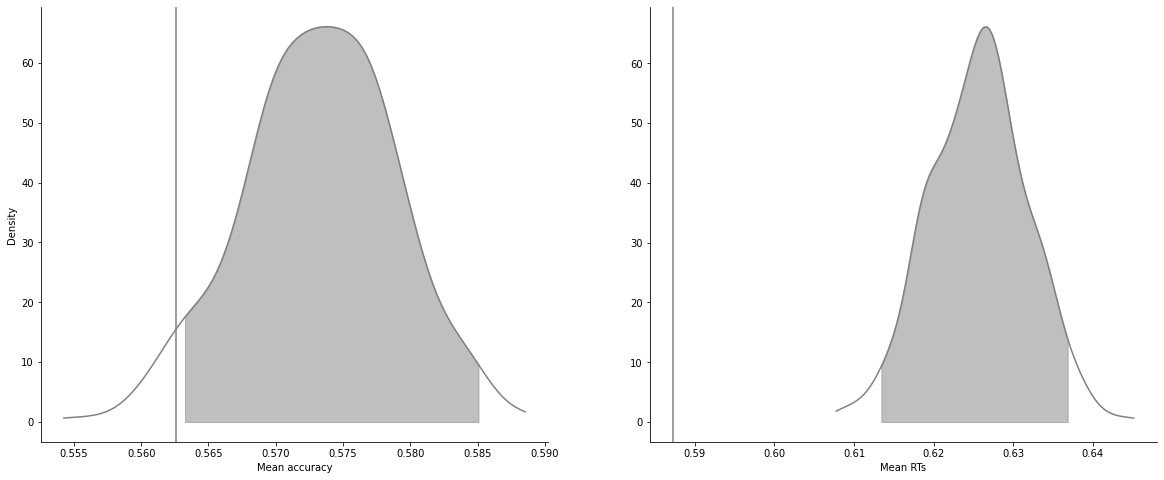

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from rlssm import plotting
figsize=(20, 8)
post_pred_kws=None
n_posterior_predictives = 500
if post_pred_kws is None:
    post_pred_kws = {}
    pp_df = get_posterior_predictives_summary(fits_DDM.DDMFittedModel,n_posterior_predictives, **post_pred_kws)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    plotting.plot_mean_prediction(pp_df,
                                      fits_DDM.DDMFittedModel.data_info['data'],
                                      y_data='accuracy',
                                      y_predictions='mean_accuracy',
                                      ax=axes[0])
                                     # **kwargs)

    plotting.plot_mean_prediction(pp_df,
                                      fits_DDM.DDMFittedModel.data_info['data'],
                                      y_data='rt',
                                      y_predictions='mean_rt',
                                      ax=axes[1])
                                      #**kwargs)

    axes[0].set_xlabel('Mean accuracy')
    axes[1].set_xlabel('Mean RTs')
    axes[0].set_ylabel('Density')
    sns.despine()


#### plotting quantiles_posterior_predictives

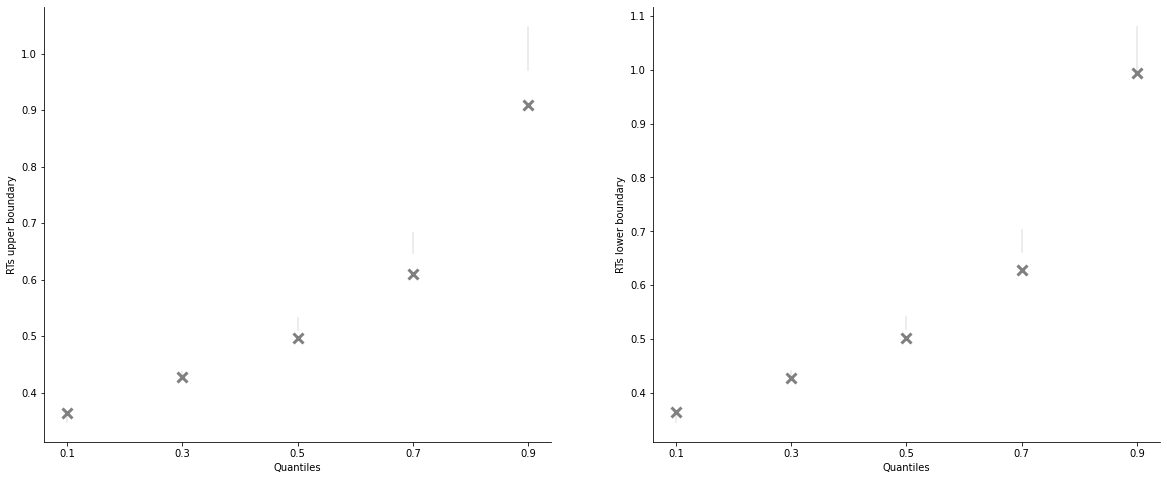

In [61]:
figsize=(20, 8)
post_pred_kws=None   
quantiles = [.1, .3, .5, .7, .9]
n_posterior_predictives = 500

if post_pred_kws is None:
    post_pred_kws = {}

pp_summary = get_posterior_predictives_summary(fits_DDM.DDMFittedModel,
            n_posterior_predictives=n_posterior_predictives,
            quantiles=quantiles,
            **post_pred_kws)

fig = plotting.plot_quantiles_prediction(pp_summary,
                                                 fits_DDM.DDMFittedModel.data_info['data'],
                                                 'ddm',
                                                 quantiles=quantiles,
                                                 figsize=figsize)
                                                 #**kwargs)

#### get_grouped_posterior_predictives_summary

In [62]:
import pickle
with open("model_fit.pkl", "wb") as f:
    pickle.dump({'model' : sm, 'fit' : fit}, f, protocol=-1)

/Users/xinyuanyan/opt/anaconda3/envs/RLDDM.stan/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
# if you want to open the results file
#with open("model_fit.pkl", "rb") as f:
 #   data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
#fit = data_dict['fit']
# fit = data_list[1]

In [64]:
resultsall=data_dict['fit']

KeyError: 'fit'

In [67]:
with open("model_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    data_list = pickle.load(f)

fitrrr = data_dict['fit']
# fit = data_list[1]

EOFError: Ran out of input

In [68]:
data_dict

{'model': <pystan.model.StanModel at 0x7f833712a210>,
 'fit': 
 For the full summary use 'print(fit)'
 
 Inference for Stan model: anon_model_bc4dd4dced0824789d173a170c757d92.
 2 chains, each with iter=1000; warmup=500; thin=1; 
 post-warmup draws per chain=500, total post-warmup draws=1000.
 
                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
 mu_alpha             -0.41  6.7e-3   0.11  -0.62  -0.48  -0.41  -0.34  -0.18    269    1.0
 mu_drift_scaling      2.44    0.03   0.41   1.68   2.16   2.43   2.71   3.27    147    1.0
 mu_threshold          0.93  4.7e-3   0.06    0.8   0.89   0.93   0.97   1.03    159    1.0
 mu_ndt               -1.23  5.7e-3   0.04  -1.31  -1.26  -1.24   -1.2  -1.14     57   1.03
 sd_alpha               0.5  2.1e-3   0.05   0.41   0.47    0.5   0.53    0.6    532    1.0
 sd_drift_scaling      1.94    0.02   0.34    1.4   1.71   1.91   2.14   2.66    254    1.0
 sd_threshold          0.29  2.7e-3   0.05   0.22   0.25   0.

In [70]:
import arviz as az
summary = az.summary(fit)

ModuleNotFoundError: No module named 'arviz'